In [1]:
# Import packages
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Read csv file
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('https://raw.githubusercontent.com/iaujla01/DSCI100Project/main/data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [3]:
# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decide to split dataset into 75% training and 25% testing

htru_split <- initial_split(htru_data, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)

Rows: 13,424
Columns: 9
$ mean_ip        <dbl> 140.56250, 102.50781, 103.01562, 136.75000, 88.72656, …
$ sd_ip          <dbl> 55.68378, 58.88243, 39.34165, 57.17845, 40.67223, 48.7…
$ kurtosis_ip    <dbl> -0.23457141, 0.46531815, 0.32332837, -0.06841464, 0.60…
$ skew_ip        <dbl> -0.69964840, -0.51508791, 1.05116443, -0.63623837, 1.1…
$ mean_dmsnr     <dbl> 3.1998328, 1.6772575, 3.1212375, 3.6429766, 1.1789298,…
$ sd_dmsnr       <dbl> 19.110426, 14.860146, 21.744669, 20.959280, 11.468720,…
$ kurtosis_dmsnr <dbl> 7.975532, 10.576487, 7.735822, 6.896499, 14.269573, 19…
$ skew_dmsnr     <dbl> 74.24222, 127.39358, 63.17191, 53.59366, 252.56731, 47…
$ class          <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, …
Rows: 4,474
Columns: 9
$ mean_ip        <dbl> 93.57031, 107.25000, 134.96094, 114.36719, 136.09375, …
$ sd_ip          <dbl> 46.69811, 52.62708, 49.55433, 51.94572, 51.69100, 56.3…
$ kurtosis_ip    <dbl> 0.531904850, 0.452688025, -0.135303833, -0.094498904, …
$ ske

In [9]:
options(repr.plot.height = 7, repr.plot.width = 15)
set.seed(3456)  

htru_tune <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) %>%
                              set_engine("kknn") %>%
                              set_mode("classification")

htru_recipe <- recipe(class ~. , data = htru_train)%>%
               step_scale(all_predictors()) %>%
               step_center(all_predictors())

In [10]:
set.seed(3456)  
htru_vfold <- vfold_cv(htru_train, v = 5, strata = class)
#have tried more folds, but no staticall significants. 
gridvals <- tibble(neighbors = 1:14)
htru_results <- workflow() %>%
                add_recipe(htru_recipe) %>%
                add_model(htru_tune) %>%
                tune_grid(resamples = htru_vfold, grid = gridvals) %>%
                collect_metrics()

htru_results

accuracies <- htru_results %>% 
       filter(.metric == "accuracy")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9703516,5,0.0010576403,Model01
1,roc_auc,binary,0.9065340,5,0.0031275907,Model01
2,accuracy,binary,0.9703516,5,0.0010576403,Model02
2,roc_auc,binary,0.9319133,5,0.0019611904,Model02
3,accuracy,binary,0.9784713,5,0.0005058789,Model03
3,roc_auc,binary,0.9393872,5,0.0025824495,Model03
4,accuracy,binary,0.9784713,5,0.0005058789,Model04
4,roc_auc,binary,0.9432162,5,0.0030458713,Model04
5,accuracy,binary,0.9795142,5,0.0004571308,Model05


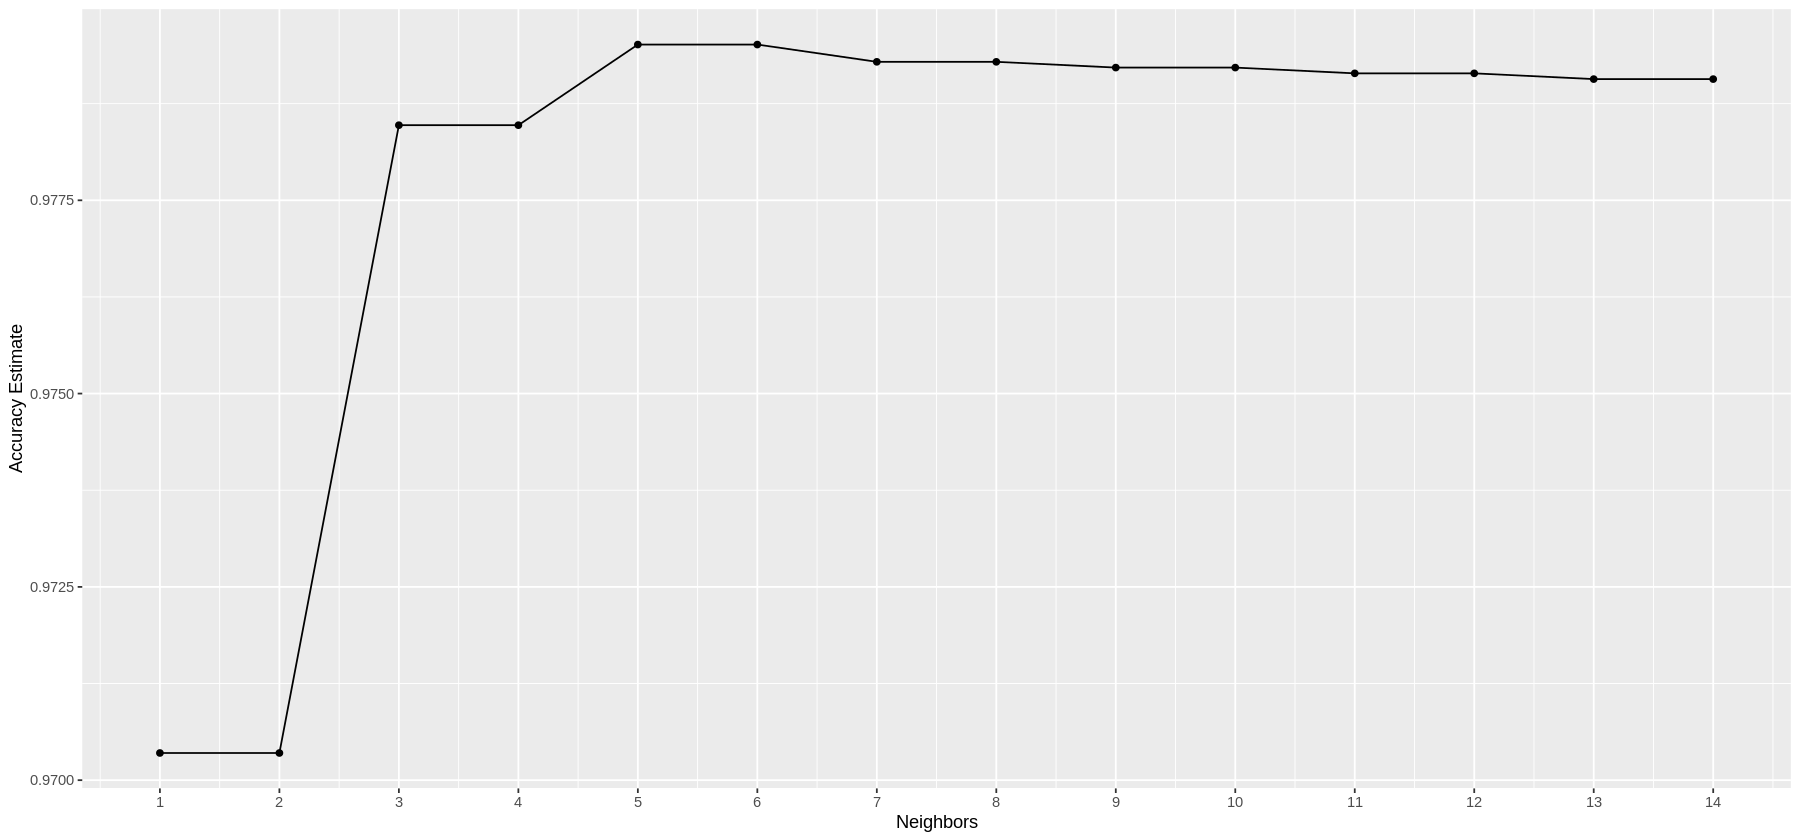

In [11]:
set.seed(3456)  
cross_val_plot  <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1))

cross_val_plot 



In [12]:
set.seed(3456)  
htru_max <- htru_results %>%
  filter(mean == max(mean))

htru_max

htru_max_number <- htru_max %>%
                   slice(1) %>%       #we have two same mean accuracy here, so I've pick one of the tibble.
                   pull(neighbors)%>%
                   as.integer()

htru_spec_max <- nearest_neighbor(weight_func = "rectangular", neighbors = htru_max_number) %>%
  set_engine("kknn") %>%
  set_mode("classification")


htru_fit <- workflow() %>%
  add_recipe(htru_recipe) %>%
  add_model(htru_spec_max) %>%
  fit(data = htru_train)

htru_summary <- htru_fit %>%
  predict(htru_test) %>%
  bind_cols(htru_test) %>%
  metrics(truth = class, estimate = .pred_class) %>%
  filter(.metric == 'accuracy')

htru_summary

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.9795142,5,0.0004571308,Model05
6,accuracy,binary,0.9795142,5,0.0004571308,Model06


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.976084


In [13]:
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection
